# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
       car        dog       ship      plane


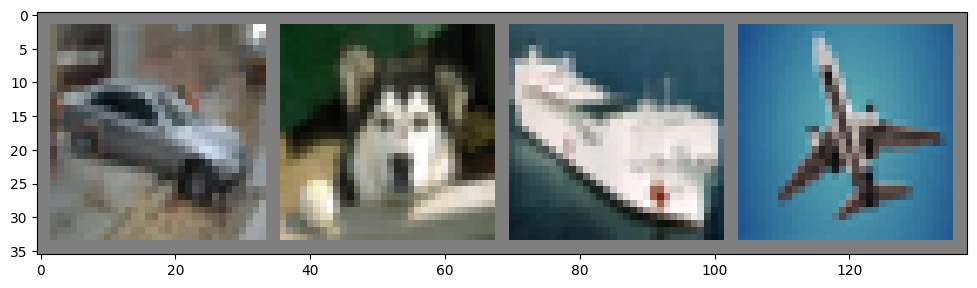

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs. 
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [4]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, 3)  # Output size: 30x30 => 15x15 after pooling
        self.conv2 = nn.Conv2d(48, 128, 3) # Output size: 13x13 => 6x6 after pooling
        self.conv3 = nn.Conv2d(128, 192, 3, padding=1) # Output size: 6x6
        self.conv4 = nn.Conv2d(192, 192, 3, padding=1) # Output size: 6x6
        self.conv5 = nn.Conv2d(192, 128, 3) # Output size: 4x4 => 2x2 afer pooling

        self.pool = nn.MaxPool2d(2, 2)  # Halves the dimensions
        
        self.fc1 = nn.Linear(128 * 2 * 2, 1000)  # Correct input size based on the output of conv3 and pooling
        self.fc2 = nn.Linear(1000, 80)
        self.fc3 = nn.Linear(80, 10)  # CIFAR-10 has 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x= self.pool(F.relu(self.conv5(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   # 
#############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.015, momentum=0.9)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

[1,    40] loss: 2.303
[1,    80] loss: 2.304
[1,   120] loss: 2.303
[1,   160] loss: 2.302
[1,   200] loss: 2.302
[1,   240] loss: 2.299
[1,   280] loss: 2.296
[1,   320] loss: 2.267
[1,   360] loss: 2.197
[1,   400] loss: 2.088
[1,   440] loss: 2.024
[1,   480] loss: 1.975
[1,   520] loss: 1.928
[1,   560] loss: 1.911
[1,   600] loss: 1.847
[1,   640] loss: 1.833
[1,   680] loss: 1.794
[1,   720] loss: 1.720
[1,   760] loss: 1.741
[2,    40] loss: 1.643
[2,    80] loss: 1.640
[2,   120] loss: 1.622
[2,   160] loss: 1.616
[2,   200] loss: 1.577
[2,   240] loss: 1.531
[2,   280] loss: 1.521
[2,   320] loss: 1.527
[2,   360] loss: 1.446
[2,   400] loss: 1.456
[2,   440] loss: 1.444
[2,   480] loss: 1.366
[2,   520] loss: 1.377
[2,   560] loss: 1.379
[2,   600] loss: 1.354
[2,   640] loss: 1.335
[2,   680] loss: 1.340
[2,   720] loss: 1.288
[2,   760] loss: 1.272
[3,    40] loss: 1.227
[3,    80] loss: 1.213
[3,   120] loss: 1.248
[3,   160] loss: 1.196
[3,   200] loss: 1.104
[3,   240] 

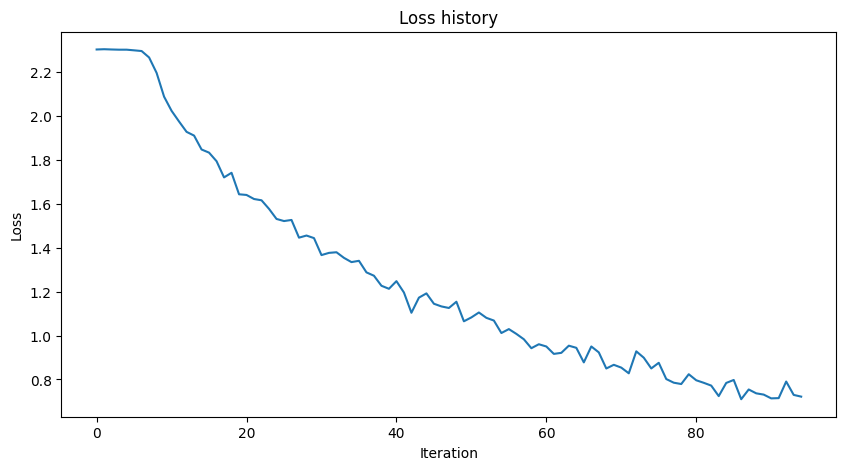

In [5]:
# Initialize an empty list to store the loss values for all epochs
loss_history = []
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 40))
            loss_history.append(running_loss / 40)
            running_loss = 0.0

print('Finished Training')
plt.figure(figsize=(10,5))
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)** 

In [6]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(len(predicted)):
            confusion_matrix[labels[i]][predicted[i]] += 1

model_accuracy = 100 * correct / total
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 73.58%


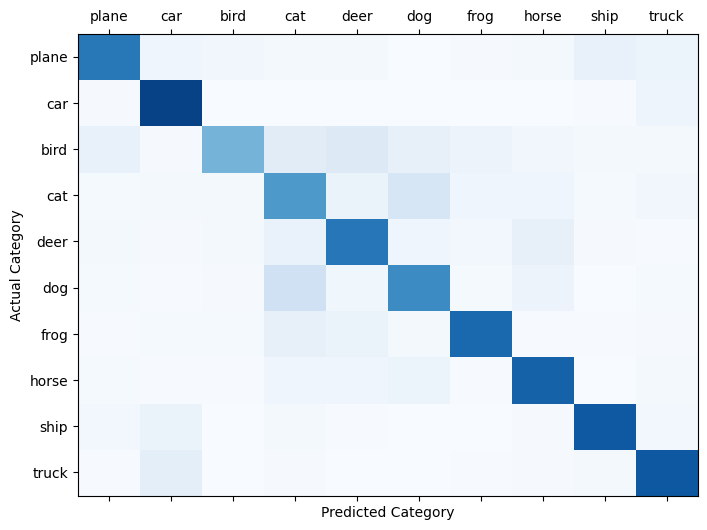

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:** 
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** I ended up using a similar architecture to alexnet. From my experiments, using a big filter doesn't work well for this data set as, I think, we lose too much information. 
In addition, using a filter of 1 doesn't work as well, as, I think, we don't get information out of using it. 
Using a big fully connected layer at the start also impoved the performance, as it's able to extract more information out of the densed data.
In addition, playing with strides didn't seem to do much.

##**Question:** 
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:** We can learn from confusion matrices, an accurate represintation of how accurate our model is.
It's not enough as there might be imbalanced data, which can lead to an innacurate sense of a good model by it just predicting the majority class most of the time.
In addition, different models can have similar accuracies but differ in how they achieve that accuracy. For example, one model might be very conservative, rarely making positive predictions but being highly accurate when it does (high precision, low recall), while another might make many positive predictions, catching more actual positives but also making more mistakes (low precision, high recall). Metrics like the precision-recall curve or F1 score help to compare and select models based on the specific needs of an application.

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [8]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [9]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [10]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [11]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 1200x800 with 0 Axes>

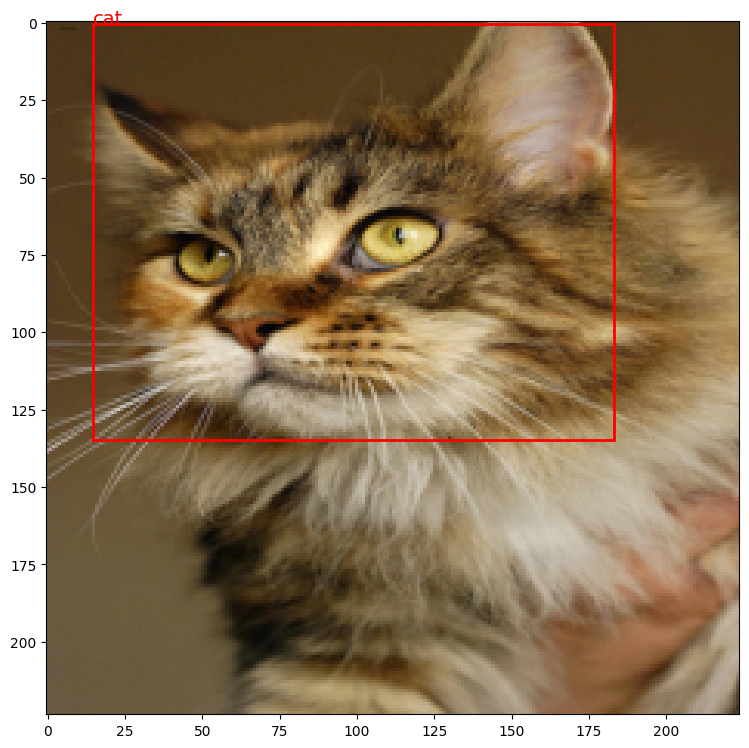

In [12]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [13]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only       #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # Clarrification - You required to build 2 models - one for classification  #
        # and one for detection.                                                    #
        # The classification model is of shape: resent_features -> FC/FCs -> scores.#
        # The detection model is of shape: resent_features -> FC/FCs -> bbox.       #
        # You may train/leave frozen the resent_features backbone, try              #
        # experimenting with it.                                                    #
        # This function has no return value.                                        #
        #############################################################################        
        # Get the number of features in the last layer
        numFeatures = resnet18.fc.in_features
        
        # Remove the last layer (fully connected layer) of the ResNet-18
        self.baseModel = nn.Sequential(*list(resnet18.children())[:-1])

        # Classification model
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the features extracted by the ResNet backbone
            nn.Linear(numFeatures, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Added dropout for regularization
            nn.Linear(512, num_classes)
        )

        # Detection model
        self.detection = nn.Sequential(
            nn.Flatten(),  # Flatten the features extracted by the ResNet backbone
            nn.Linear(numFeatures, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Added dropout for regularization
            nn.Linear(512, 4)  # x, y, width, height for bounding box
        )
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        features = self.baseModel(images)
    
        # Pass the extracted features through the classification and detection models
        class_pred = self.classifier(features)
        bbox_coords = self.detection(features)
    
        return class_pred, bbox_coords
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [14]:
from data import dataloader as dl
history_dict = {
    'train_loss': [],
    'train_acc': [],
    'train_iou': [],
    'val_loss': [],
    'val_acc': [],
    'val_iou': []
}

def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_iou = 0.0

            for sample in dataloaders[phase]:
                inputs = sample['image']
                labels = sample['label']
                bboxes = sample['bbox']

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs, pred_bboxes = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss_cls = criterion_cls(outputs, labels)
                    loss_bbox = criterion_bbox(pred_bboxes, bboxes)
                    loss = loss_cls + loss_bbox

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_iou += sum(dl.bb_intersection_over_union(pred_bboxes[i], bboxes[i]) for i in range(len(pred_bboxes)))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_iou = total_iou / dataset_sizes[phase]

            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_iou))

            if phase == 'train':
                history_dict['train_loss'].append(epoch_loss)
                history_dict['train_acc'].append(epoch_acc.item())
                history_dict['train_iou'].append(epoch_iou)
            else:
                history_dict['val_loss'].append(epoch_loss)
                history_dict['val_acc'].append(epoch_acc.item())
                history_dict['val_iou'].append(epoch_iou)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [15]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
criterion_cls = torch.nn.CrossEntropyLoss()
criterion_bbox = torch.nn.SmoothL1Loss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [16]:
best_model = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.2935  |  Acc: 0.9072  |  IOU: 0.4795
val Loss: 6.3299  |  Acc: 0.5823  |  IOU: 0.4883
Epoch 2/10
----------
train Loss: 0.2418  |  Acc: 0.9088  |  IOU: 0.6565
val Loss: 8.7715  |  Acc: 0.5443  |  IOU: 0.5429
Epoch 3/10
----------
train Loss: 0.1088  |  Acc: 0.9575  |  IOU: 0.6773
val Loss: 1.0834  |  Acc: 0.8671  |  IOU: 0.7027
Epoch 4/10
----------
train Loss: 0.1122  |  Acc: 0.9733  |  IOU: 0.6934
val Loss: 0.3373  |  Acc: 0.9051  |  IOU: 0.7153
Epoch 5/10
----------
train Loss: 0.0790  |  Acc: 0.9780  |  IOU: 0.6997
val Loss: 0.3040  |  Acc: 0.8924  |  IOU: 0.7459
Epoch 6/10
----------
train Loss: 0.0710  |  Acc: 0.9811  |  IOU: 0.7031
val Loss: 0.1576  |  Acc: 0.9430  |  IOU: 0.7449
Epoch 7/10
----------
train Loss: 0.1019  |  Acc: 0.9686  |  IOU: 0.6962
val Loss: 0.3092  |  Acc: 0.8608  |  IOU: 0.7383
Epoch 8/10
----------
train Loss: 0.0628  |  Acc: 0.9858  |  IOU: 0.7077
val Loss: 0.3153  |  Acc: 0.9114  |  IOU: 0.7565
Epoch 9/10
----------
tr

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

<Figure size 1200x800 with 0 Axes>

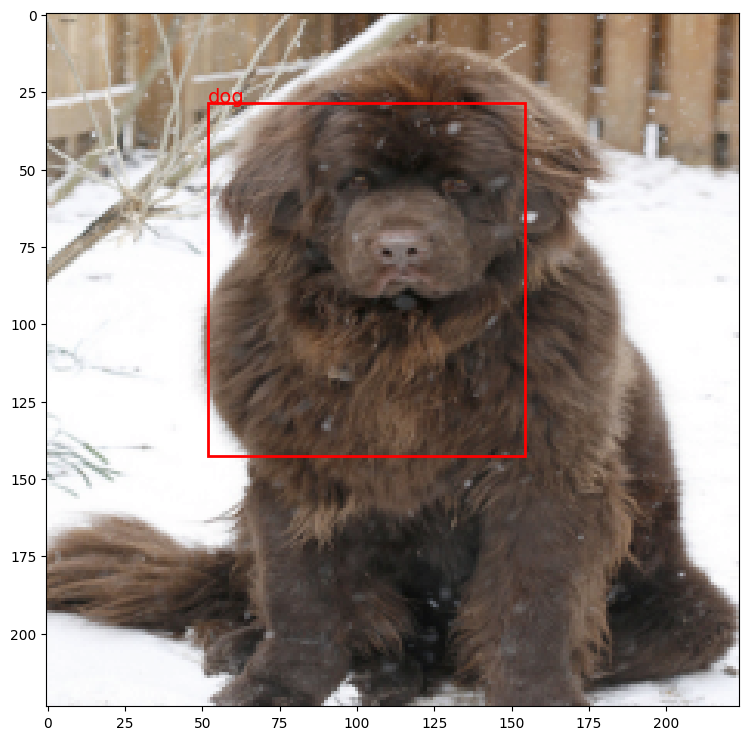

In [25]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

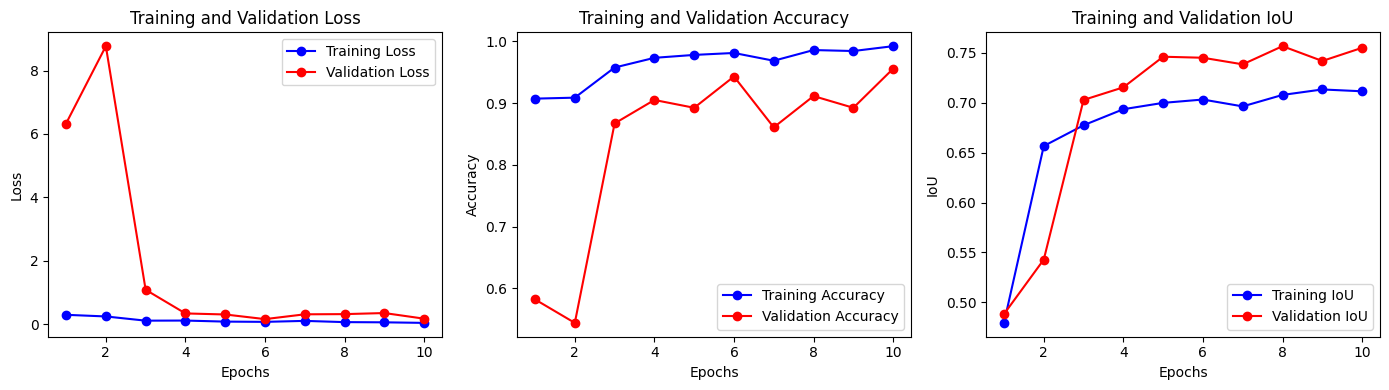

In [18]:
epochs = range(1, len(history_dict['train_loss']) + 1)

plt.figure(figsize=(14, 4))

# Plotting training and validation loss
plt.subplot(1, 3, 1)
plt.plot(epochs, history_dict['train_loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, history_dict['train_acc'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history_dict['val_acc'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation IoU
plt.subplot(1, 3, 3)
plt.plot(epochs, [t.detach().numpy() for t in history_dict['train_iou']], 'bo-', label='Training IoU')
plt.plot(epochs, [t.detach().numpy() for t in history_dict['val_iou']], 'ro-', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

Result Explination:
As seen above, as studied in class we observe the power of transfer learning. As seen with resnet already trained on a really large dataset,utilizing it for specific related tasks only requires small modification and a small training process to achieve great results.